## Predictive Model Selection.

### Step 1 - Importing the Necessary Modules and Loading the Data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
%matplotlib inline
pd.options.display.max_columns = 15
plt.style.use('fivethirtyeight')

In [2]:
#loading the dataset

df = pd.read_csv('finalxgdata.csv')
df1 = pd.read_csv('xgdata.csv')
df.head()

,shotDist,shotAng,isOnTarget,isGoal,isHeader,isBigChance,isCounter,isTapIn,isThroughball,isGround,goalLoc,minute
0,8.000000,90.000000,1,1,0,0,0,0,0,0,s11,53
1,2.236068,63.434949,1,1,0,0,0,0,0,1,s17,54
2,4.472136,63.434949,1,0,0,0,0,0,0,1,s21,54
3,4.123106,75.963757,1,0,0,0,0,0,0,1,s16,55
4,3.000000,90.000000,1,0,0,0,0,0,1,1,s21,55


In [3]:
X = df.loc[:,df.columns!='isGoal']
y=df['isGoal']

X.head()

,shotDist,shotAng,isOnTarget,isHeader,isBigChance,isCounter,isTapIn,isThroughball,isGround,goalLoc,minute
0,8.000000,90.000000,1,0,0,0,0,0,0,s11,53
1,2.236068,63.434949,1,0,0,0,0,0,1,s17,54
2,4.472136,63.434949,1,0,0,0,0,0,1,s21,54
3,4.123106,75.963757,1,0,0,0,0,0,1,s16,55
4,3.000000,90.000000,1,0,0,0,0,1,1,s21,55


### Step 2 - Transforming the Columns to Account for Categories and Numericals.

In [4]:
#intializing scaler and encoder
ohe=OneHotEncoder(sparse=False)
ss = StandardScaler()

#selecting categorical and numerical columns
cat_columns = ['goalLoc']
num_columns = ['shotDist','shotAng','isOnTarget','isHeader','isBigChance','isCounter','isTapIn','isThroughball','isGround','minute']

transformers = [('cat',ohe,cat_columns),('num',ss,num_columns)]

ct = ColumnTransformer(transformers,remainder='passthrough') 
X_t = ct.fit_transform(X)

### Step 3 - Splitting our Data into Training and Test Data.

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_t,y, test_size=0.3, stratify=y)

### Step 4 - Testing Different Models.

The models we will test:
* Logistic Regression
* Random Forest Classifier
* XGBoost

##### 4.1 - First, let's try out Logistic Regression:

In [7]:
from sklearn.linear_model import LogisticRegression

In [157]:
#initializing a default logistic regression model and fitting to our training data
log_reg = LogisticRegression()
log_reg.fit(X_train,y_train)

LogisticRegression()

In [158]:
y_train_pred = log_reg.predict(X_train)
y_train_proba = log_reg.predict_proba(X_train)

In [159]:
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve

In [160]:
def plot_roc_curve(y,y_model_proba,model_label):
    fpr,tpr,thresholds = roc_curve(y,y_model_proba[:,1]) # extracting probability for positive class
    plt.plot(fpr,tpr,label=model_label)
    plt.plot([0,1],[0,1])
    plt.ylim([-0.1,1.1])
    plt.xlim([-0.1,1.1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right');

The auc score for the logit model on the training data is 0.9


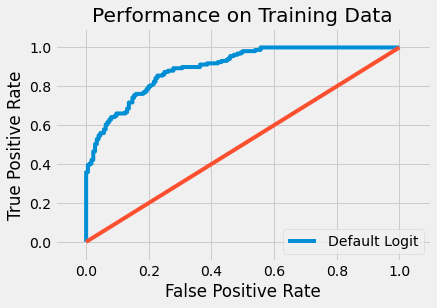

In [161]:
plot_roc_curve(y_train,y_train_proba,model_label='Default Logit')
plt.title('Performance on Training Data');
print('The auc score for the logit model on the training data is {}'.format(round(roc_auc_score(y_train,y_train_proba[:,1]),2)))

The auc score for the logit model on the test data is 0.842


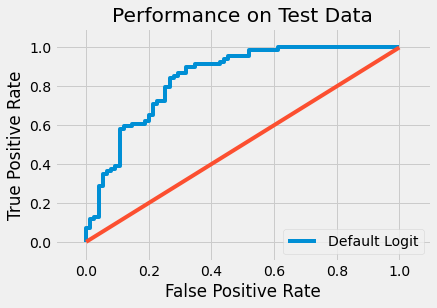

In [112]:
y_test_pred = log_reg.predict(X_test)
y_test_proba = log_reg.predict_proba(X_test)

plot_roc_curve(y_test,y_test_proba,model_label='Default Logit')
plt.title('Performance on Test Data');

print('The auc score for the logit model on the test data is {}'.format(round(roc_auc_score(y_test,y_test_proba[:,1]),3)))

#### Let's try and improve the performance of the model.

In [113]:
from sklearn.model_selection import GridSearchCV

In [124]:
# as gridsearch does not improve model performance, we will comment it out while working with the smaller dataset

# param_grid = {'C':[0.001,0.1,1,10,100]}
# gs_logit = GridSearchCV(LogisticRegression(),param_grid,scoring='roc_auc',cv=5)
# gs_logit.fit(X_train,y_train)
# gs_logit.best_params_

In [125]:
logit_best = gs_logit.best_estimator_
logit_best.fit(X_train,y_train)


y_test_proba = logit_best.predict_proba(X_test)
print('The auc score for the logit model on the test data is {}'.format(round(roc_auc_score(y_test,y_test_proba[:,1]),3)))

The auc score for the logit model on the test data is 0.842


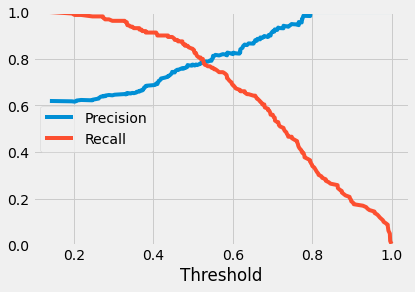

In [126]:
precisions,recalls,thresholds = precision_recall_curve(y_train,y_train_proba[:,1])

def plot_precision_recall_vs_threshold(precisions,recalls,thresholds):
    ''' From Hands On Machine Learning with Scikit-Learn and TensorFlow by 
    Aurelien Geron
    '''
    plt.plot(thresholds,precisions[:-1],label='Precision')
    plt.plot(thresholds,recalls[:-1],label='Recall')
    plt.xlabel('Threshold')
    plt.legend(loc='center left')
    plt.ylim([0,1])

plot_precision_recall_vs_threshold(precisions,recalls,thresholds)

As we see very clearly, precision and recall share an inverse relationship with each other and both seem to be a consequence of the threshold.

In [127]:
from sklearn.metrics import confusion_matrix

In [162]:
predict_new = np.where(y_test_proba[:,1]>0.4,1,0)
print(confusion_matrix(y_test,predict_new))

[[51 24]
 [15 54]]


In [130]:
#saving best logistic regression model
from joblib import dump
dump(logit_best,'best_logit.joblib')

['best_logit.joblib']

##### Next, let's try Random Forest Classifier:

In [132]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_jobs=-1)
rnd_clf.fit(X_train,y_train)

RandomForestClassifier(n_jobs=-1)

The auc score for the Default Random Forest model on the training data is 1.0


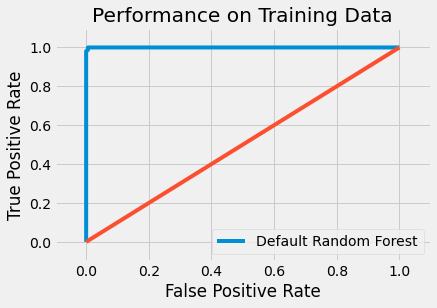

In [164]:
y_train_proba = rnd_clf.predict_proba(X_train)

plot_roc_curve(y_train,y_train_proba,model_label='Default Random Forest')
plt.title('Performance on Training Data');

print('The auc score for the Default Random Forest model on the training data is {}'.format(round(roc_auc_score(y_train,y_train_proba[:,1]),3)))

#### Improving the performance of the model:

This model is clearly overfitting to the data, so let's try and use gridsearchcv to arrive at the best parameters to train the data. 

In [135]:
param_grid = {'n_estimators':[10,100,500,1000],'max_leaf_nodes':[10,15,20,25,30],'max_features':[5,10,15,'auto','log2',None]}
gs_rnd = GridSearchCV(RandomForestClassifier(n_jobs=-1),param_grid,cv=5,scoring='roc_auc')
gs_rnd.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=-1),
             param_grid={'max_features': [5, 10, 15, 'auto', 'log2', None],
                         'max_leaf_nodes': [10, 15, 20, 25, 30],
                         'n_estimators': [10, 100, 500, 1000]},
             scoring='roc_auc')

In [136]:
gs_rnd.best_params_

{'max_features': 15, 'max_leaf_nodes': 20, 'n_estimators': 500}

The auc score for the Best RF model on the test data is 0.823
The auc score for the Best RF model on the training data is 0.967


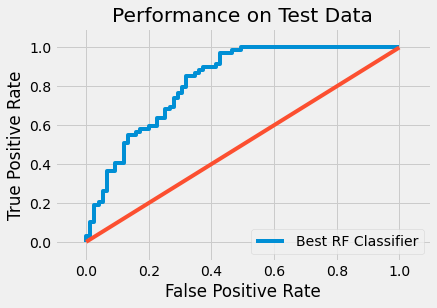

In [153]:
best_rnd = gs_rnd.best_estimator_
best_rnd.fit(X_train,y_train)

y_test_proba = best_rnd.predict_proba(X_test)
y_train_proba = best_rnd.predict_proba(X_train)

plot_roc_curve(y_test,y_test_proba,model_label='Best RF Classifier')
plt.title('Performance on Test Data');
print('The auc score for the Best RF model on the test data is {}'.format(round(roc_auc_score(y_test,y_test_proba[:,1]),3)))
print('The auc score for the Best RF model on the training data is {}'.format(round(roc_auc_score(y_train,y_train_proba[:,1]),3)))

We see above that while the model is still overfitting to the training data, the updated model does slightly better and provides a reasonably well fit on the test data as well, however the logistic regression model still performs better.

In [139]:
# saving the best rfc model
dump(best_rnd,'best_random_forest.joblib')

['best_random_forest.joblib']

##### Finally, let's try out XGBoost:

In [144]:
import xgboost as xgb

In [145]:
xg_clf = xgb.XGBClassifier()
xg_clf.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

The auc score for the Default xgboost model on the training data is 1.0


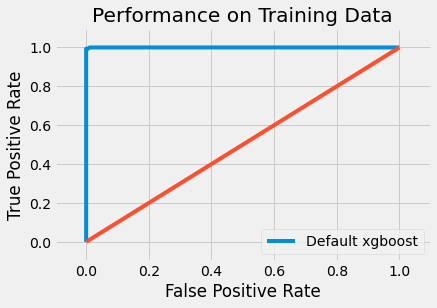

In [146]:
y_train_proba = xg_clf.predict_proba(X_train)
plot_roc_curve(y_train,y_train_proba,model_label='Default xgboost')
plt.title('Performance on Training Data');

print('The auc score for the Default xgboost model on the training data is {}'.format(round(roc_auc_score(y_train,y_train_proba[:,1]),3)))


We see yet another case of overfitting with xgboost. As we did earlier, we shall use gridsearchcv to find the most suitable parameters.

In [147]:
param_grid = {'n_estimators':[50,100,250,500],'learning_rate':[0.1,0.25],'max_depth':[1,2,3],
             'subsample':[0.25,0.5,0.75], 'colsample_bytree':[0.1,0.5,1]}
gs_xgb = GridSearchCV(xgb.XGBClassifier(n_jobs=-1,),param_grid,cv=5,scoring='roc_auc')
gs_xgb.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=-1,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, v

In [149]:
gs_xgb.best_params_

{'colsample_bytree': 0.5,
 'learning_rate': 0.25,
 'max_depth': 1,
 'n_estimators': 50,
 'subsample': 0.75}

The auc score for the Best XGB model on the test data is 0.826
The auc score for the Best XGB model on the training data is 0.895


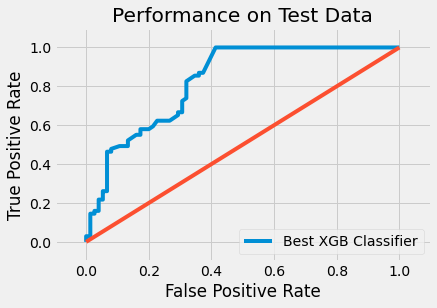

In [155]:
best_xgb = gs_xgb.best_estimator_
best_xgb.fit(X_train,y_train)


y_test_proba = best_xgb.predict_proba(X_test)
y_train_proba = best_xgb.predict_proba(X_train)

plot_roc_curve(y_test,y_test_proba,model_label='Best XGB Classifier')
plt.title('Performance on Test Data');
print('The auc score for the Best XGB model on the test data is {}'.format(round(roc_auc_score(y_test,y_test_proba[:,1]),3)))
print('The auc score for the Best XGB model on the training data is {}'.format(round(roc_auc_score(y_train,y_train_proba[:,1]),3)))

In [156]:
# saving the best xgb
dump(best_xgb,'best_xgb.joblib')

['best_xgb.joblib']

As we see above, the updated xgboost model performs better on the test data. However, the logistic regression still appears to be the best model for prediciting shot probabilities. So we shall stick to using the logistic regression model for further analysis.